In [29]:
import os

new_path = '/capstor/scratch/cscs/ajayaraj/qtpyt-tests/AuBDA13CH2/dft_fd_1e-2'
os.chdir(new_path)

In [30]:
from pathlib import Path

import numpy as np
import tqdm
from edpyt.espace import build_espace, screen_espace
from edpyt.gf2_lanczos import build_gf2_lanczos
from edpyt.shared import params
from matplotlib import pyplot as plt

from scipy.signal import find_peaks

In [31]:
# class Sigma:

#     def __init__(self, gf0, gf, H_eff, eta=1e-5):
#         self.gf0 = gf0
#         self.gf = gf
#         self.eta = eta
#         self.H_eff = H_eff

#     def retarded(self, energy):
#         energies = np.atleast_1d(energy)
#         g0 = self.gf0(energies, self.eta)
#         g = self.gf(energies, self.eta)
#         sigma = np.empty((energies.size,self.gf.n,self.gf.n), complex)
#         for e, energy in enumerate(energies):
#             # sigma[e] = np.linalg.inv(g0[...,e]) - np.linalg.inv(g[...,e])
#             sigma[e] = energy - self.H_eff - np.linalg.inv(g[...,e])
#         return sigma

class Sigma:

    def __init__(self, gf, H_eff, eta=1e-5):
        self.gf = gf
        self.eta = eta
        self.H_eff = H_eff

    def retarded(self, energy):
        energies = np.atleast_1d(energy)
        g = self.gf(energies, self.eta)
        sigma = np.empty((energies.size,self.gf.n,self.gf.n), complex)
        for e, energy in enumerate(energies):
            sigma[e] = energy - self.H_eff - np.linalg.inv(g[...,e])
        return sigma


In [32]:
path = Path('/capstor/scratch/cscs/ajayaraj/qtpyt-tests/AuBDA13CH2/dft_fd_1e-2/output/lowdin')
H_eff = np.load(path/'effective_hamiltonian.npy')
nimp = H_eff.shape[0]
occupancy_goal = np.load(path/"occupancies/occupancies_gfp_mu_0.0.npy")

In [33]:
de = 0.01
energies = np.arange(-2, 2 + de / 2.0, de).round(7)
eta = 1e-2
z = energies + eta*1.j
beta = 100.
params['z'] = occupancy_goal

In [34]:
# V = np.eye(nimp)*4
V = np.loadtxt('/capstor/scratch/cscs/ajayaraj/qtpyt-tests/AuBDA13CH2/dft_fd_1e-2/ed/U_matrix.txt')
DC = np.diag(V.diagonal()*(occupancy_goal-0.5))
# neig = get_active_neig(nimp, [(nimp//2,nimp//2)], 3)
neig = np.ones((nimp+1)*(nimp+1),int) * 4

In [35]:
# espace, egs = build_espace(H_eff, np.zeros_like(H_eff), neig_sector=neig)
# screen_espace(espace, egs, beta)
# gf0 = build_gf2_lanczos(H_eff, np.zeros_like(H_eff), espace, beta, egs)
# # TODO Look at implementing build_gf_lanczos here instead of build_gf2_lanczos
# DOS0 = -1/np.pi * gf0(energies, eta).imag.trace(axis1=0,axis2=1)

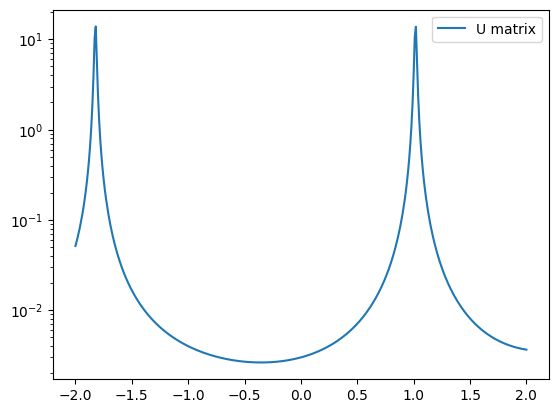

In [36]:
espace, egs = build_espace(H_eff-DC, V, neig_sector=neig)
screen_espace(espace, egs, beta)
gf = build_gf2_lanczos(H_eff-DC, V, espace, beta, egs)
DOS = -1/np.pi * gf(energies, eta).imag.trace(axis1=0,axis2=1)

# plt.plot(energies, DOS0, label="U=0")
plt.plot(energies, DOS, label="U matrix")
plt.legend()
plt.yscale('log')
plt.show()

In [23]:
# g0 = gf0(energies, eta)
# g = gf(energies, eta)
# plt.plot(energies, g0.real.trace(axis1=0,axis2=1), label="G0")
# plt.plot(energies, g.real.trace(axis1=0,axis2=1), label="G")
# plt.legend()
# plt.show()
# plt.plot(energies, g0.imag.trace(axis1=0,axis2=1), label="G0")
# plt.plot(energies, g.imag.trace(axis1=0,axis2=1), label="G")
# plt.legend()
# plt.show()

In [24]:
# plt.plot(energies, g0.real.trace(axis1=0,axis2=1)-g.real.trace(axis1=0,axis2=1))
# plt.show()
# plt.plot(energies, g0.imag.trace(axis1=0,axis2=1)-g.imag.trace(axis1=0,axis2=1))
# plt.show()

In [37]:
# sigma = Sigma(gf0, gf, H_eff, eta=eta)
sigma = Sigma(gf, H_eff, eta=eta)
sig = sigma.retarded(energies)
output_path = Path('/capstor/scratch/cscs/ajayaraj/qtpyt-tests/AuBDA13CH2/dft_fd_1e-2/output/lowdin/ed')
np.save(output_path/'ed_sigma.npy', sig)
sig = np.load(output_path/'ed_sigma.npy')
sig_trace = np.trace(sig,axis1=1,axis2=2)

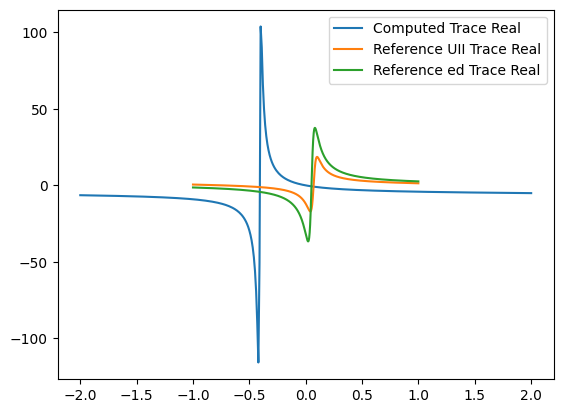

Real part peak positions (computed): [-0.4]
Real part dip positions (computed): [-0.42]
Real part peak positions (reference): [0.101]
Real part dip positions (reference): [0.041]


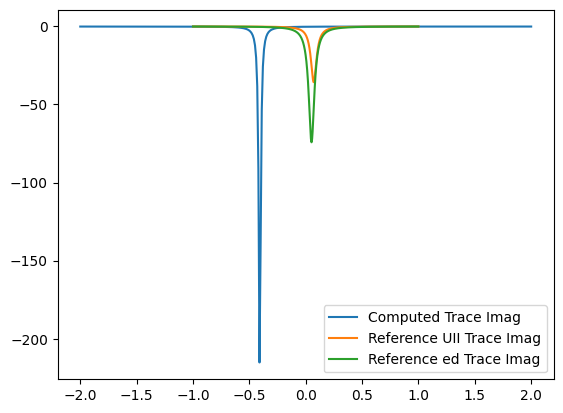

Imaginary part peak positions (computed): []
Imaginary part dip positions (computed): [-0.41]
Imaginary part peak positions (reference): []
Imaginary part dip positions (reference): [0.071]


In [38]:
reference_path = Path('/capstor/scratch/cscs/ajayaraj/qtpyt-tests/AuBDA13CH2/reference')

ref_sig_uii_trace = np.loadtxt(reference_path/'sigma_ed_uii_trace.txt')
ref_sig_ed_trace = np.loadtxt(reference_path/'sigma_ed_trace.txt')

# Plot the real part of the trace
plt.plot(energies, sig_trace.real, label="Computed Trace Real")
plt.plot(ref_sig_uii_trace[:, 0], ref_sig_uii_trace[:, 1], label="Reference UII Trace Real")
plt.plot(ref_sig_ed_trace[:, 0], ref_sig_ed_trace[:, 1], label="Reference ed Trace Real")
plt.legend()
plt.show()

# Find and print peaks and dips for the real part of the computed trace
real_peaks, _ = find_peaks(sig_trace.real)
real_dips, _ = find_peaks(-sig_trace.real)
real_peak_positions = energies[real_peaks]
real_dip_positions = energies[real_dips]
print("Real part peak positions (computed):", real_peak_positions)
print("Real part dip positions (computed):", real_dip_positions)

# Find and print peaks and dips for the real part of the reference trace
ref_real_peaks, _ = find_peaks(ref_sig_uii_trace[:, 1])
ref_real_dips, _ = find_peaks(-ref_sig_uii_trace[:, 1])
ref_real_peak_positions = ref_sig_uii_trace[ref_real_peaks, 0]
ref_real_dip_positions = ref_sig_uii_trace[ref_real_dips, 0]
print("Real part peak positions (reference):", ref_real_peak_positions)
print("Real part dip positions (reference):", ref_real_dip_positions)

# Plot the imaginary part of the trace
plt.plot(energies, sig_trace.imag, label="Computed Trace Imag")
plt.plot(ref_sig_uii_trace[:, 0], ref_sig_uii_trace[:, 2], label="Reference UII Trace Imag")
plt.plot(ref_sig_ed_trace[:, 0], ref_sig_ed_trace[:, 2], label="Reference ed Trace Imag")
plt.legend()
plt.show()

# Find and print peaks and dips for the imaginary part of the computed trace
imag_peaks, _ = find_peaks(sig_trace.imag)
imag_dips, _ = find_peaks(-sig_trace.imag)
imag_peak_positions = energies[imag_peaks]
imag_dip_positions = energies[imag_dips]
print("Imaginary part peak positions (computed):", imag_peak_positions)
print("Imaginary part dip positions (computed):", imag_dip_positions)

# Find and print peaks and dips for the imaginary part of the reference trace
ref_imag_peaks, _ = find_peaks(ref_sig_uii_trace[:, 2])
ref_imag_dips, _ = find_peaks(-ref_sig_uii_trace[:, 2])
ref_imag_peak_positions = ref_sig_uii_trace[ref_imag_peaks, 0]
ref_imag_dip_positions = ref_sig_uii_trace[ref_imag_dips, 0]
print("Imaginary part peak positions (reference):", ref_imag_peak_positions)
print("Imaginary part dip positions (reference):", ref_imag_dip_positions)
